In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("Using CPU - training will be slower")

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB


In [ ]:
# Enhanced data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=test_transform)


100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


In [ ]:
#optimized data loaders.
batch_size = 128 if torch.cuda.is_available() else 32
# Reduce num_workers to 0 and disable persistent_workers to address DataLoader error
num_workers = 0 #min(8, os.cpu_count())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers, pin_memory=True, persistent_workers=False) # Set persistent_workers to False
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True, persistent_workers=False) # Set persistent_workers to False

In [ ]:

# Improved colorization model with modern architecture
class ImprovedColorizationNet(nn.Module):
    def __init__(self):
        super(ImprovedColorizationNet, self).__init__()

        # Encoder (downsampling path)
        self.encoder1 = self._make_layer(1, 64)
        self.encoder2 = self._make_layer(64, 128)
        self.encoder3 = self._make_layer(128, 256)
        self.encoder4 = self._make_layer(256, 512)

        # Bottleneck
        self.bottleneck = self._make_layer(512, 1024)

        # Decoder (upsampling path)
        self.decoder4 = self._make_decoder_layer(1024, 512)
        self.decoder3 = self._make_decoder_layer(1024, 256)  # 512 + 512 from skip connection
        self.decoder2 = self._make_decoder_layer(512, 128)   # 256 + 256 from skip connection
        self.decoder1 = self._make_decoder_layer(256, 64)    # 128 + 128 from skip connection

        # Final output layer
        self.final_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 64 + 64 from skip connection
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=1),
            nn.Tanh()  # Better than sigmoid for normalized data
        )

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.2)

    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _make_decoder_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path with skip connections
        enc1 = self.encoder1(x)
        enc1_pool = self.pool(enc1)

        enc2 = self.encoder2(enc1_pool)
        enc2_pool = self.pool(enc2)

        enc3 = self.encoder3(enc2_pool)
        enc3_pool = self.pool(enc3)

        enc4 = self.encoder4(enc3_pool)
        enc4_pool = self.pool(enc4)

        # Bottleneck
        bottleneck = self.bottleneck(enc4_pool)
        bottleneck = self.dropout(bottleneck)

        # Decoder path with skip connections (U-Net style)
        dec4 = self.decoder4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)

        dec3 = self.decoder3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)

        dec2 = self.decoder2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)

        dec1 = self.decoder1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)

        output = self.final_conv(dec1)
        return output

In [ ]:
# Initialize model with better weight initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model = ImprovedColorizationNet().to(device)
model.apply(init_weights)

ImprovedColorizationNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, mom

In [ ]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 22,400,387
Trainable parameters: 22,400,387


In [ ]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()

    def forward(self, output, target):
        # Combine MSE and L1 loss for better color accuracy
        mse = self.mse_loss(output, target)
        l1 = self.l1_loss(output, target)
        return 0.7 * mse + 0.3 * l1

criterion = PerceptualLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                               patience=5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Improved RGB to grayscale conversion (more realistic)
def rgb_to_gray(img):
    """Convert RGB to grayscale using luminance weights"""
    weights = torch.tensor([0.299, 0.587, 0.114]).to(img.device).view(1, 3, 1, 1)
    return torch.sum(img * weights, dim=1, keepdim=True)


In [ ]:
# Training function with validation
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, _ in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device, non_blocking=True)
        grayscale_images = rgb_to_gray(images)

        optimizer.zero_grad()
        outputs = model(grayscale_images)
        loss = criterion(outputs, images)

        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def validate_epoch(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc="Validation", leave=False):
            images = images.to(device, non_blocking=True)
            grayscale_images = rgb_to_gray(images)

            outputs = model(grayscale_images)
            loss = criterion(outputs, images)
            running_loss += loss.item()

    return running_loss / len(test_loader)

# Visualization function
def visualize_results(model, test_loader, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))

    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images[:num_samples].to(device)
        grayscale_images = rgb_to_gray(images)
        colorized = model(grayscale_images)

        # Denormalize for visualization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

        images = images * std + mean
        colorized = colorized * std + mean

        for i in range(num_samples):
            # Original
            axes[0, i].imshow(images[i].cpu().permute(1, 2, 0).clamp(0, 1))
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            # Grayscale
            axes[1, i].imshow(grayscale_images[i].cpu().squeeze(), cmap='gray')
            axes[1, i].set_title('Grayscale Input')
            axes[1, i].axis('off')

            # Colorized
            axes[2, i].imshow(colorized[i].cpu().permute(1, 2, 0).clamp(0, 1))
            axes[2, i].set_title('Colorized')
            axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Enhanced training loop
EPOCHS = 3
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validation
    val_loss = validate_epoch(model, test_loader, criterion, device)
    val_losses.append(val_loss)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_colorization_model.pth')
        print(f"New best model saved! Val Loss: {val_loss:.4f}")

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Visualize results every 10 epochs
    if (epoch + 1) % 10 == 0:
        visualize_results(model, test_loader, device)

print("Finished Training!")


Starting training...

Epoch 1/3


New best model saved! Val Loss: 0.3027
Train Loss: 0.3133, Val Loss: 0.3027

Epoch 2/3


New best model saved! Val Loss: 0.3001
Train Loss: 0.3106, Val Loss: 0.3001

Epoch 3/3


New best model saved! Val Loss: 0.2984
Train Loss: 0.3097, Val Loss: 0.2984
Finished Training!


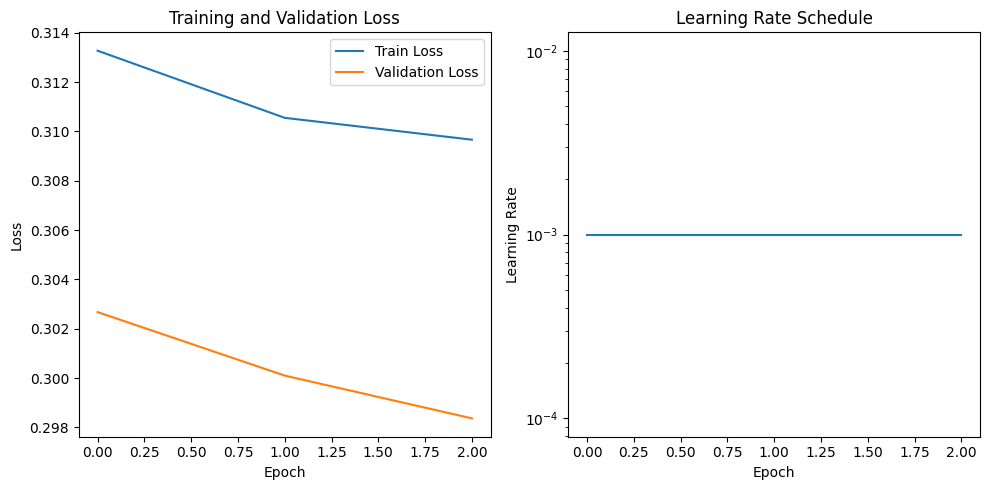

In [ ]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([scheduler.get_last_lr()[0] for _ in range(len(train_losses))])
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')

plt.tight_layout()
plt.show()


Final results:


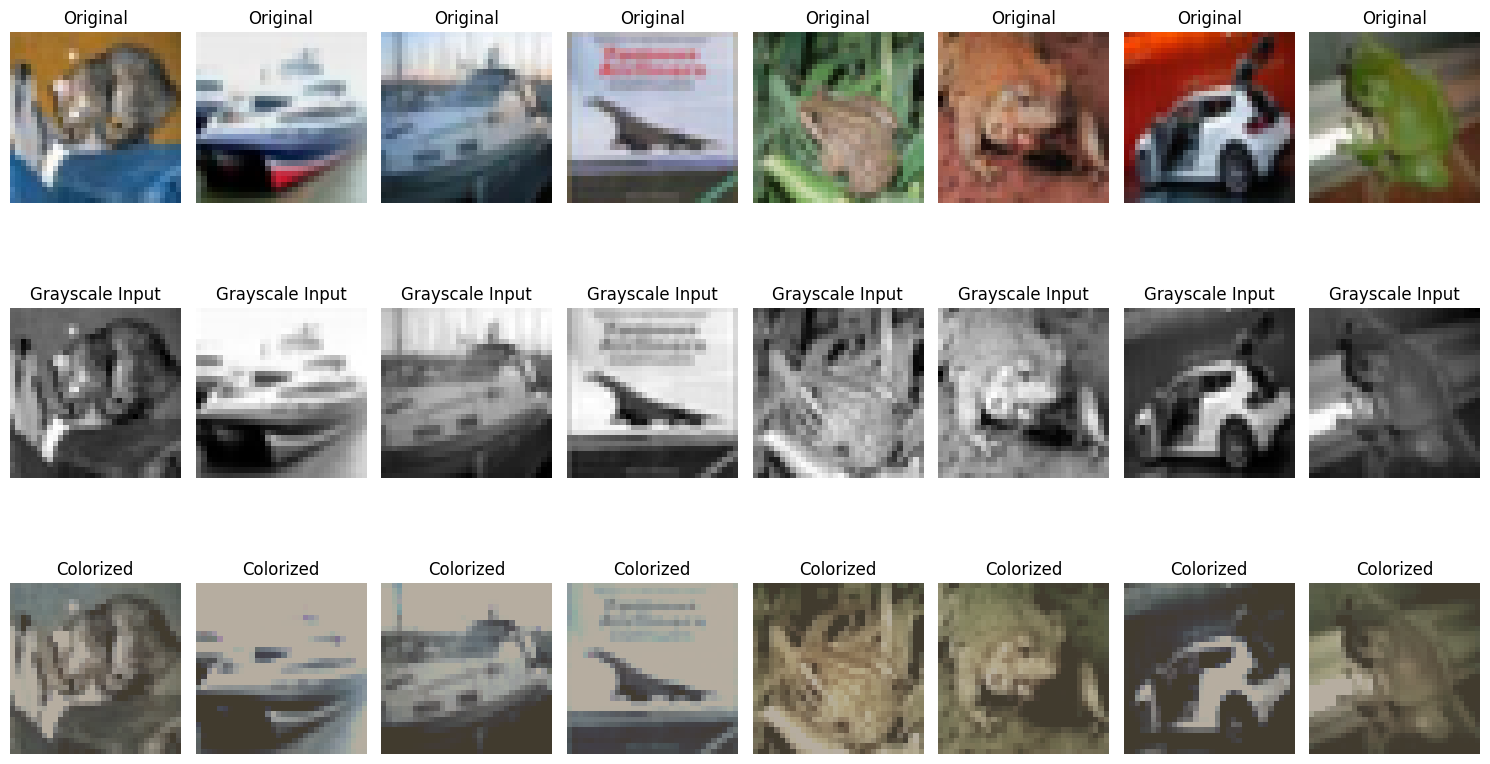

In [ ]:
print("Final results:")
visualize_results(model, test_loader, device, num_samples=8)


In [25]:
from PIL import Image

# Open the image. (Keep your image in the current directory. In my case, the image was horse.jpg)
img = Image.open("./horse.jpg")

# Convert the image to grayscale
gray_img = img.convert("L")

In [26]:
import torchvision.transforms as transforms

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # If you need to normalize, uncomment the following line
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming you want to normalize to [-1, 1] range
])



In [27]:
# Apply the transformations
img_tensor = transform(gray_img).unsqueeze(0)  # Add a batch dimension

# Ensure the model is in evaluation mode
model.eval()

# Move the image tensor to the device where your model is (likely 'cuda' if using GPU)
img_tensor = img_tensor.to(device)

# Get the model's output
with torch.no_grad():
    colorized_tensor = model(img_tensor)


In [28]:
# Convert the tensor back to an image
colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())

# Optionally, save the image
colorized_img.save("./horse_colorized.jpg")


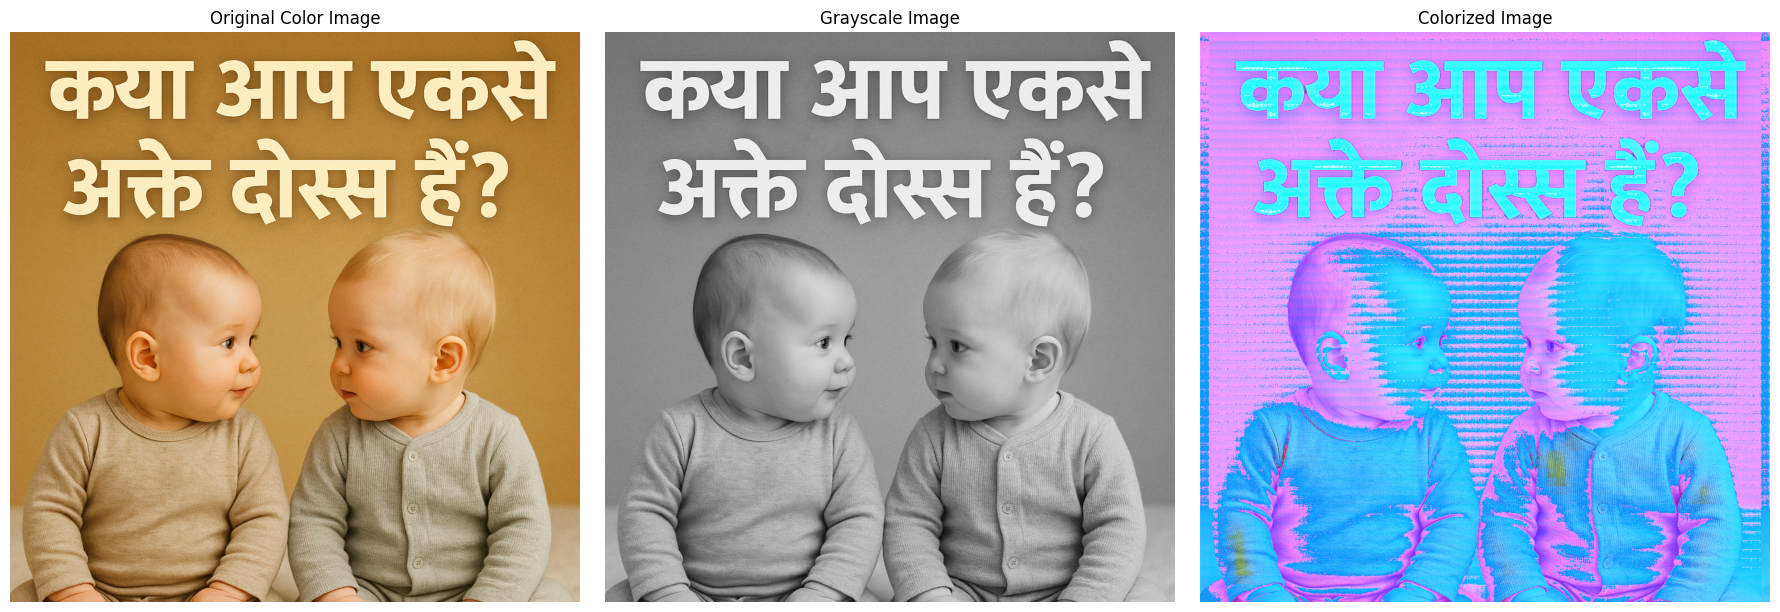

In [29]:
# Plotting the original, grayscale, and colorized images side-by-side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure with 1 row and 3 columns

# Display original color image
ax[0].imshow(img)
ax[0].set_title("Original Color Image")
ax[0].axis('off')  # Hide axes

# Display grayscale image
ax[1].imshow(gray_img, cmap='gray')  # Since it's grayscale, use cmap='gray'
ax[1].set_title("Grayscale Image")
ax[1].axis('off')  # Hide axes

# Display colorized image
ax[2].imshow(colorized_img)
ax[2].set_title("Colorized Image")
ax[2].axis('off')  # Hide axes

plt.tight_layout()  # Adjust spacing
plt.show()